In [ ]:
# %pip install -r requirements.txt


Importing required packages


In [7]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import os
import math

Importing audio 

In [8]:
audio, sr = librosa.load('Misirlou.wav', sr=16000)

In [10]:
spectrogram = librosa.stft(audio, n_fft=2048, hop_length=256, center=False, win_length=2048)
M = abs(spectrogram)
phase = spectrogram/(M + 2.2204e-16)
M.shape

(1025, 1978)

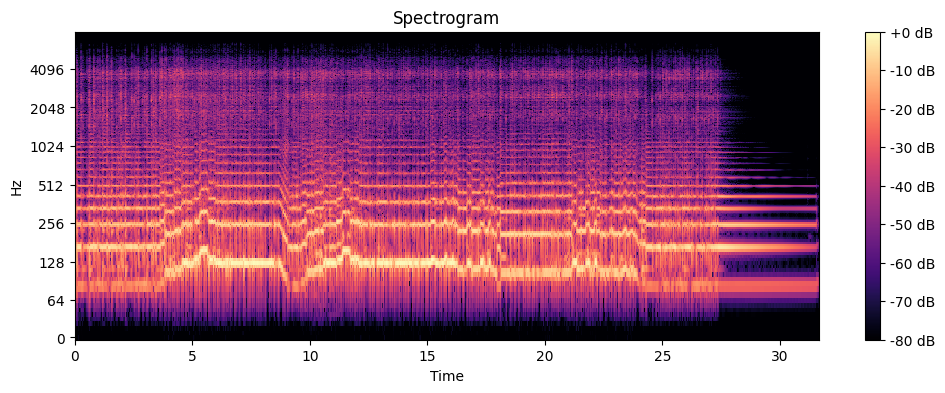

In [11]:
plt.figure(figsize=(12, 4))
librosa.display.specshow(librosa.amplitude_to_db(M, ref=np.max),
                         sr=sr, hop_length=256, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

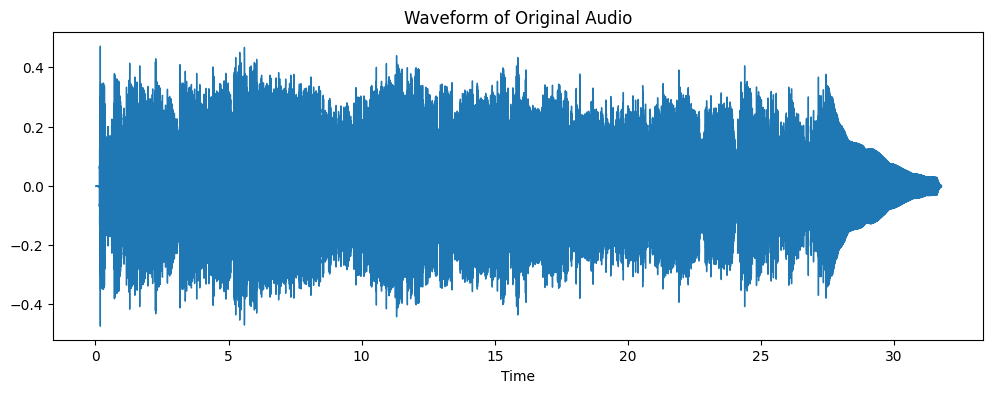

In [12]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(audio, sr=sr)
plt.title('Waveform of Original Audio')
plt.show()